In [31]:
%matplotlib ipympl
import numpy as np
from numpy.fft import  ifft2, ifftshift
from numpy.random import default_rng as randn
#from scipy.special import kv as beselk
from matplotlib import pyplot as plt
from ipywidgets import interact, widgets
from ows import ows
from ows import fouriertransform as mathft
import time

rad2asec = 3600 * 180/np.pi
asec2rad = 1/rad2asec

## PSD
Power spectrum density

3.90625e-07


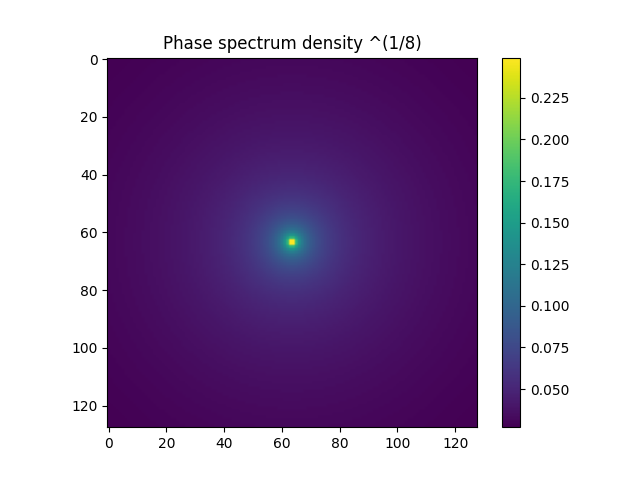

In [32]:
dimmat = 128   # Matrix size
r0 = .0001
L0 = -1

FoV = 60 # arcsec
Npx = 100 # image plane pixels qty

Daf = 0.01#asec2rad*FoV/Npx # [rad/px]  (Numerical aperture)
wl = 500e-9 # [m]

dfp = Daf/wl # [/m] Pupil plane spatial frequency pixel size (Numerical aperture/WL)
dxp = 1/(dfp*dimmat) # Pupil plane pixel size
#DFP = 1/dxp/dimmat
print(dxp)
PSD = ows.psd(dimmat, dxp, r0, wl)

plt.close(1)
plt.figure(1)
plt.imshow(PSD**(1/8))
plt.title("Phase spectrum density ^(1/8)")
plt.colorbar()

## Phase screen

Processingtime : 68.29404830932617 ms


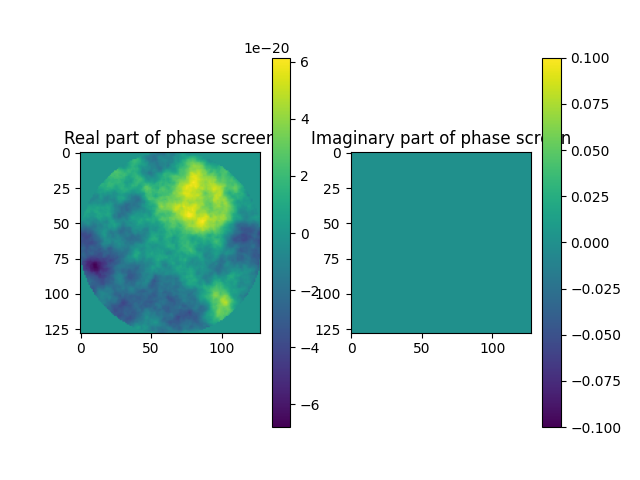

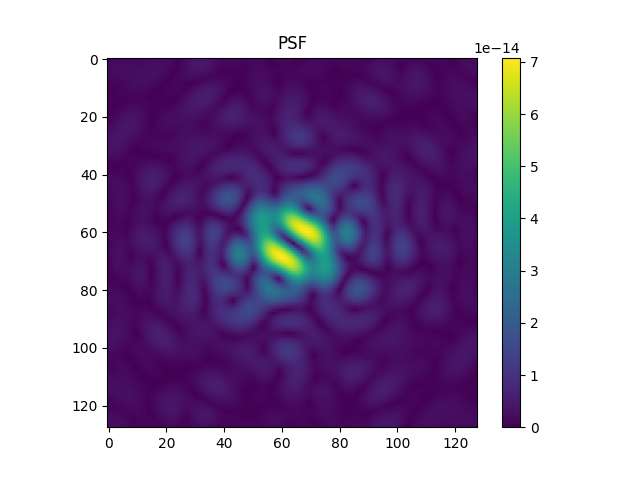

In [43]:
SEED = None

def phase_screen(dimmat, PSD, dxp, SEED = None, PUPIL = True):
    rng = np.random.default_rng(seed=SEED)

    pxR = np.linspace(-1 ,1,dimmat)*dimmat//2
    xx, yy = np.meshgrid(pxR,pxR)
    R= np.sqrt(xx**2 + yy**2)  # pupil plane spatial frequency radius

    PP = np.zeros((dimmat+1, dimmat+1)) # Phase power [dimmat+1, dimmat+1] in order to have a pixcele in the middle [rad^2/m^-2]
   
    PP[0:dimmat,0:dimmat] = PSD*(dimmat*dxp)**2
    PP[0 : dimmat, dimmat] = PP[0 : dimmat, 0] # last row = 1st row
    PP[dimmat,0 : dimmat] = PP[0, 0 : dimmat] # last column = 1st column
    PP[dimmat, dimmat] = PP[0, 0] # bottom right corner = top left corner

    if SEED is not None:
      np.random.seed(SEED)
    PSA = np.sqrt(PP)* rng.normal(0, 1, size=(dimmat+1, dimmat+1)) # random draw to create a random phase spectrum [rad/m^(-1)] AMPLITUDE
    PSA = np.sqrt(2)*(PSA+np.rot90(np.rot90(PSA,2)))/2 # forced even amplitude of wf spectrum
    PSop = rng.normal(0, 1, size=(dimmat+1, dimmat+1))*2*np.pi # random draw for the phase of the spectrum of the optical phase
    # in order to make sure that the phase is real,
    # (1) the real part of the phase spectrum is forced to be even (as in "f(x) is even")
    # (2) the imaginary part of phase spectrum is forced to be odd (as in "f(x) is odd")
    phaseft =  (PSA * np.cos(0.5 * (PSop - np.rot90(np.rot90(PSop)))))[0:dimmat,0:dimmat] + 1j*(PSA * np.sin(0.5 * (PSop - np.rot90(np.rot90(PSop)))))[0:dimmat,0:dimmat]

    MASK = np.ones((dimmat,dimmat))
    if PUPIL is True:
      MASK[R >= dimmat//2 +1] = 0
      #TODO: implement annular pupil here
      #MASK[R < dimmat*obstruation_ratio] = 0


    phase_screen = MASK*mathft.ift2(phaseft,dxp).real
    phase_screen[MASK == 1] -= np.mean(phase_screen[MASK == 1])
    
    N_pad = 8*dimmat
    padded_pupil = np.zeros((N_pad,N_pad))
    padded_pupil[:dimmat,:dimmat] = MASK*phase_screen

    Sp = np.sum(R)*dxp**2
    #apsf = mathft((R*np.exp(phase_screen)),dxp,INVERSE=False)/Sp
    psf = mathft.ft2(padded_pupil,delta=1./dimmat)/Sp
    psf = psf[N_pad//2-dimmat//2:N_pad//2+dimmat//2,N_pad//2-dimmat//2:N_pad//2+dimmat//2]

    
    return phase_screen, psf


start = time.time()

[phase_screen, psf] = phase_screen(dimmat, PSD, dxp, SEED, PUPIL = True)

end = time.time()


print("Processingtime :",
      (end-start) * 10**3, "ms")

plt.close(3)
plt.figure(3)
plt.subplot(1,2,1)
plt.imshow((phase_screen.real))
plt.title("Real part of phase screen")
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow((phase_screen.imag))
plt.title("Imaginary part of phase screen")
plt.colorbar()
plt.show()

plt.close(4)
plt.figure(4)
plt.imshow((np.abs(psf)**(1/1)))
plt.title("PSF")
plt.colorbar()
plt.show()
